In [1]:
import numpy as np
import os as os
import h5py
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

In [6]:
# If you desire to plot the spectrogram of the samples set below to True
plot_spect = True

In [11]:
# Getting list of raw .bin files
bin_folder_fp = "/Users/hamza/Research/SDR Project/neu_bz61g073z/"               # filepath of folder contain .bin files
bin_folder = os.listdir(bin_folder_fp)      # list of files in folder

In [12]:
# Filepath of folder that will contain the converted h5 files
h5_folder_fp = "/Users/hamza/Research/SDR Project/sdr_wifi_h5/"
if not os.path.isdir(h5_folder_fp):
    os.mkdir(h5_folder_fp)

In [21]:
# Parameters for training 1D CNN
buf = 32                           # Size of input to CNN in number of I/Q samples
stride = 12                         # To create overlap between samples (if no overlap desired set stride = buf)"
nsamples_per_file = 10000           # Number of buf sized training/testing samples to be gathered from each .bin file

# Number of complex values to read from .bin file to generate desired amount of training/testing samples
# If you want to read all the complex values set niq2read = -1
niq2read = (nsamples_per_file-1) * stride + buf

# Number of complex values to skip over before reading
offset = 0

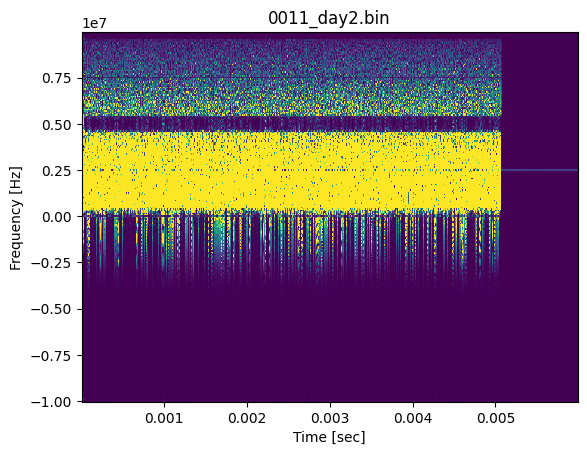

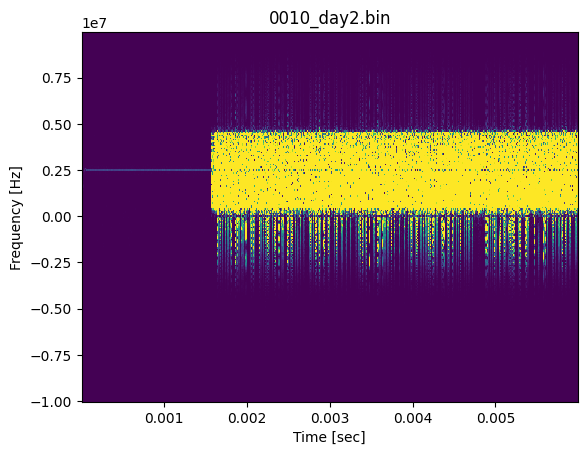

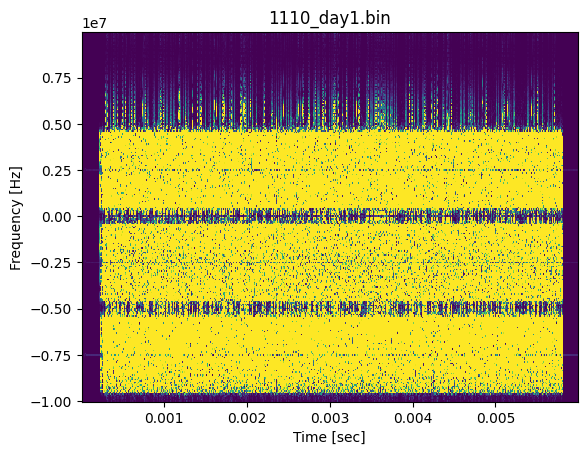

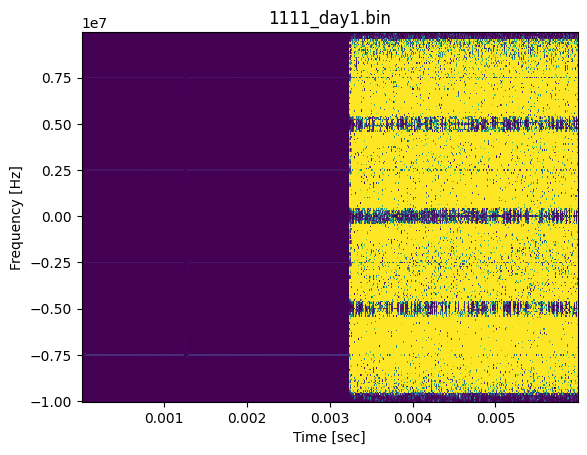

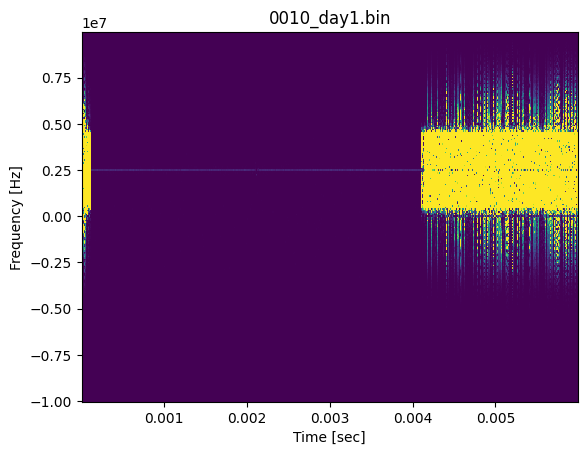

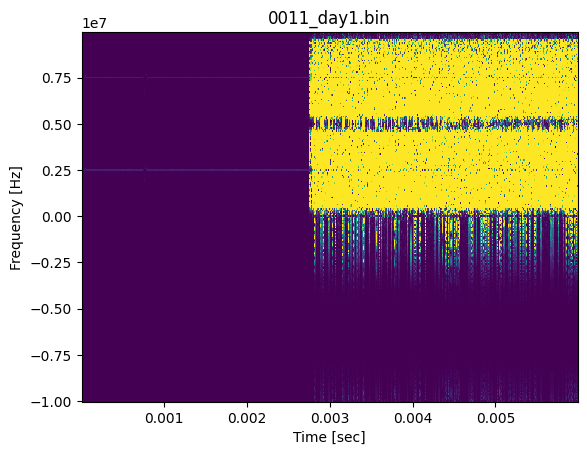

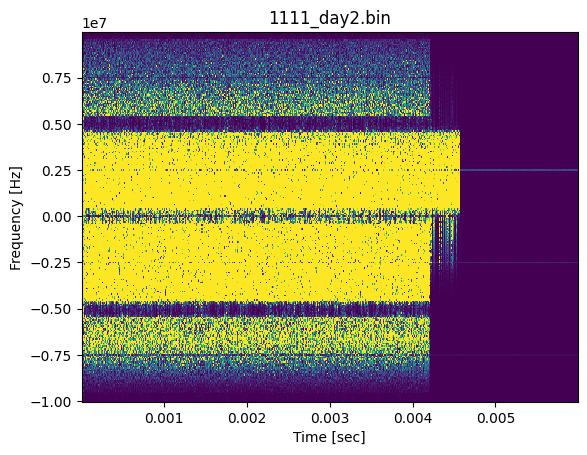

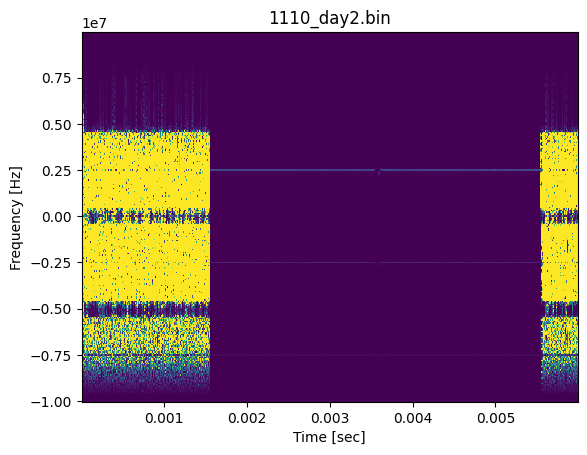

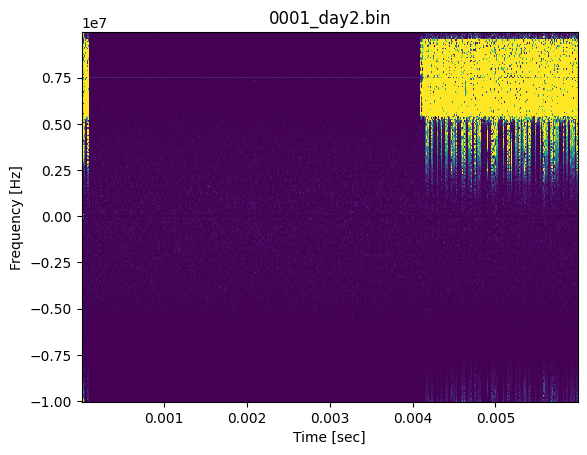

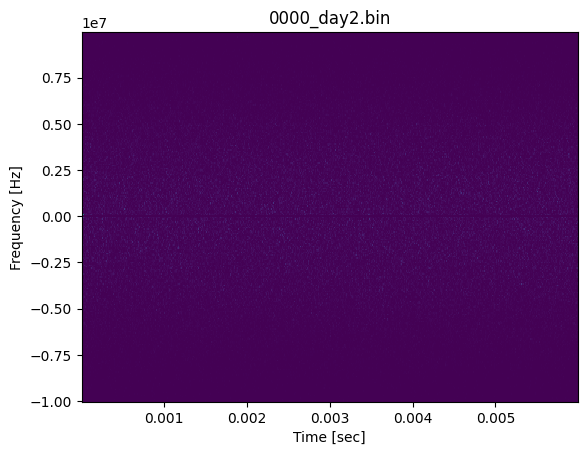

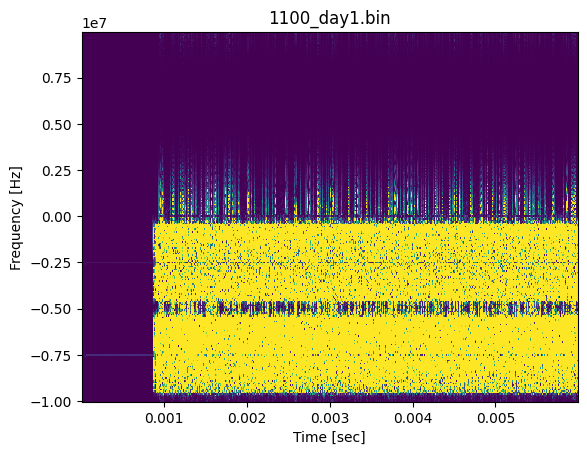

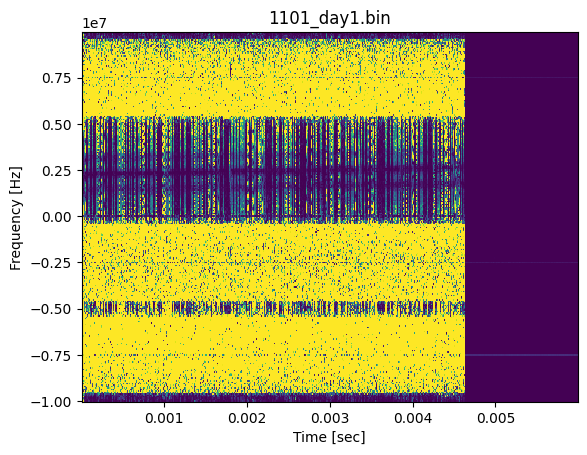

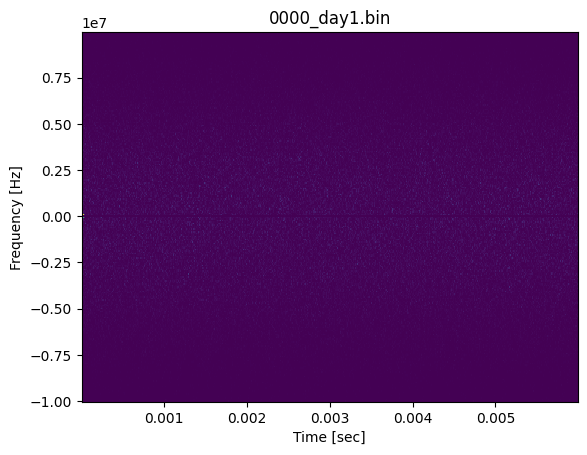

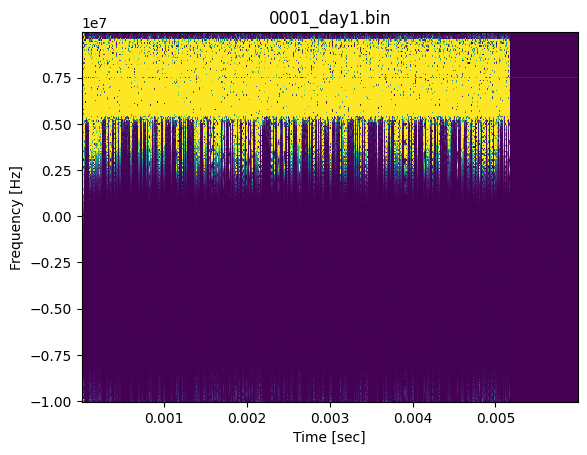

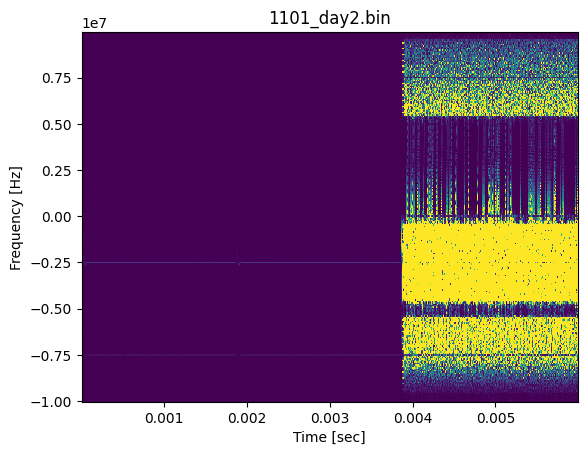

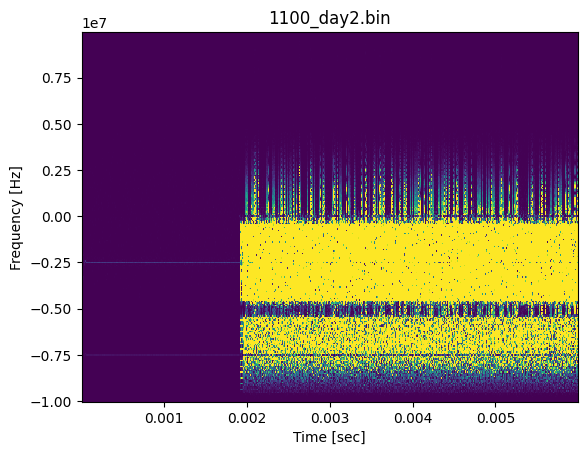

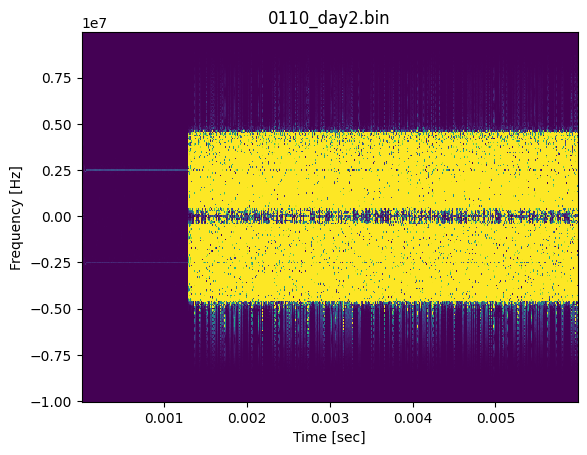

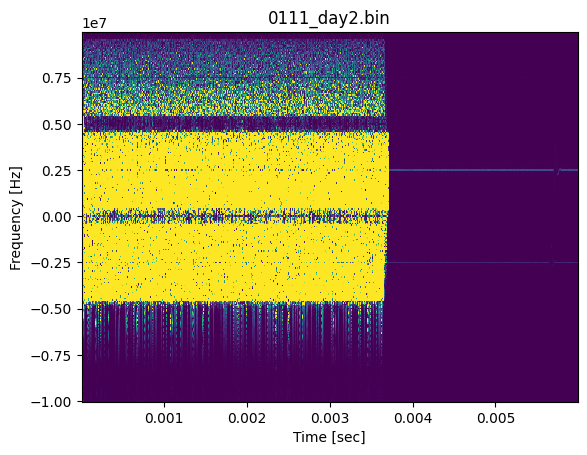

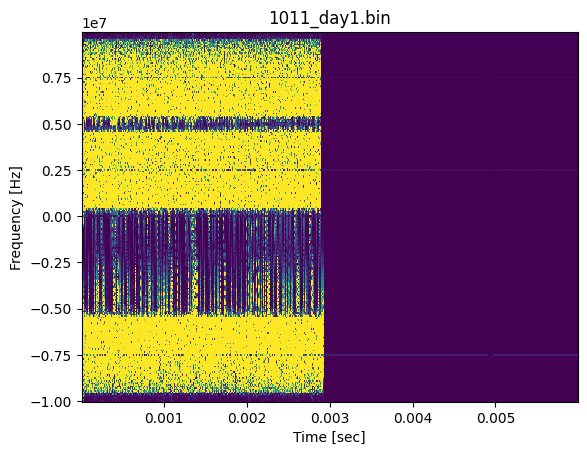

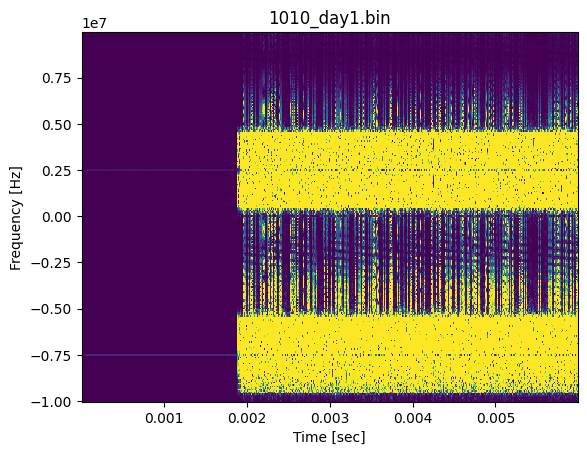

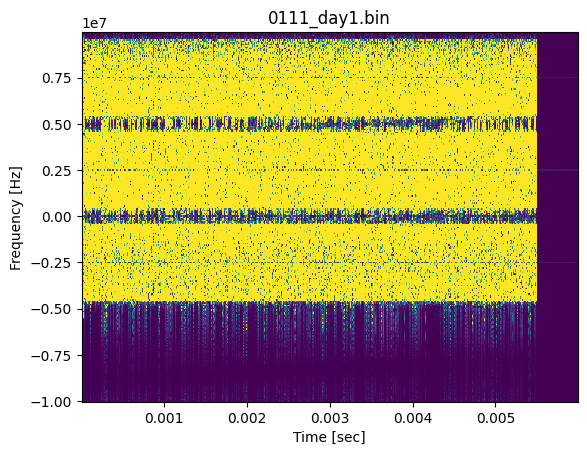

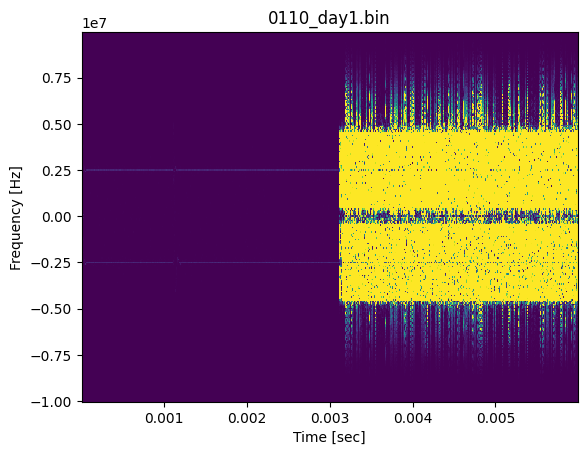

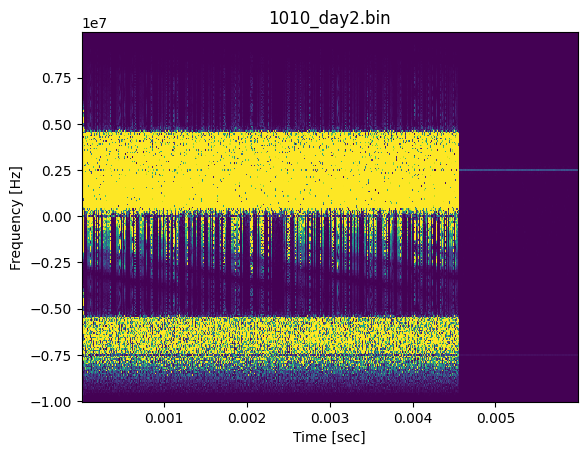

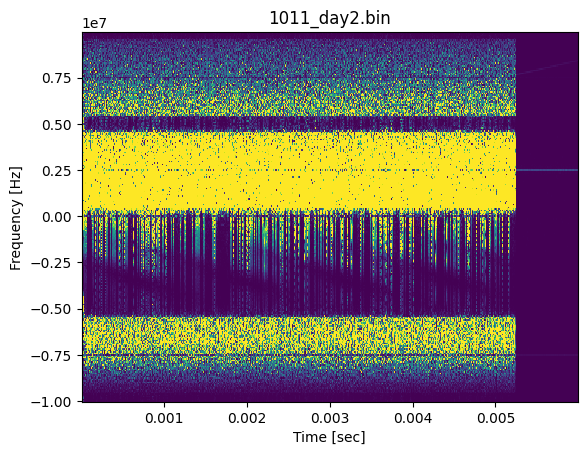

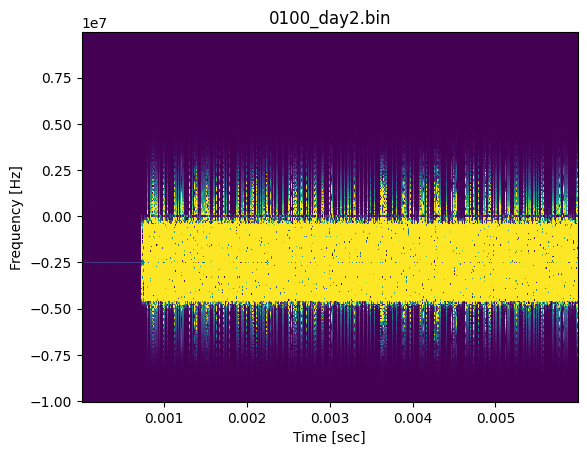

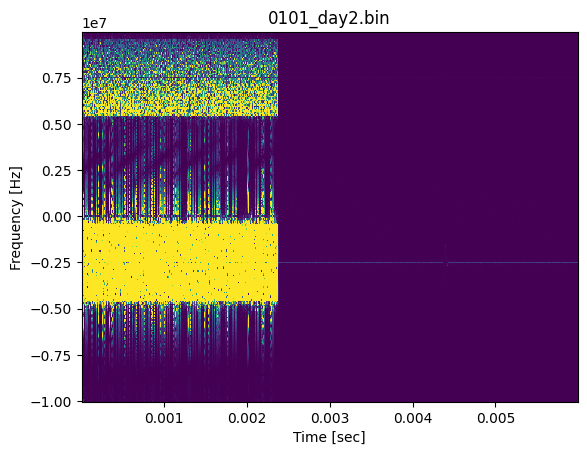

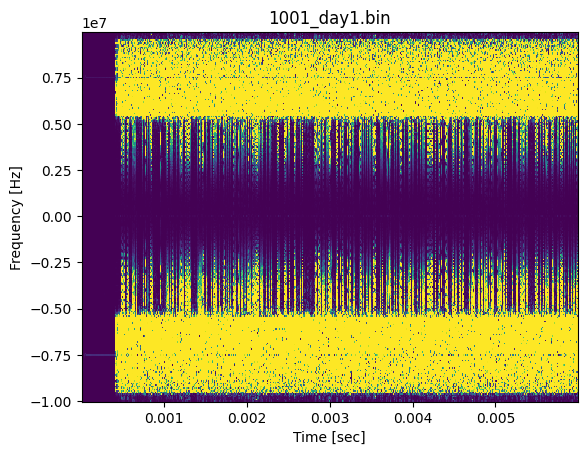

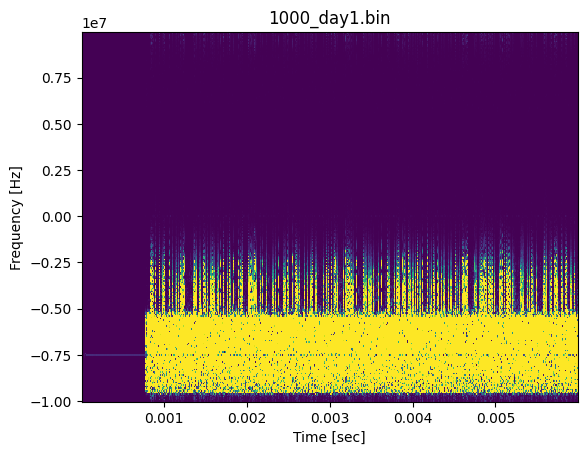

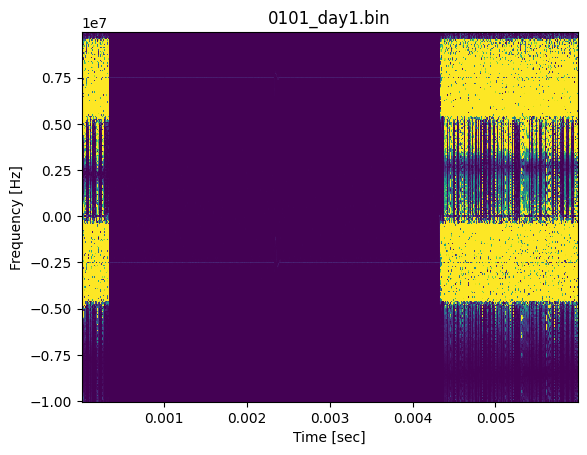

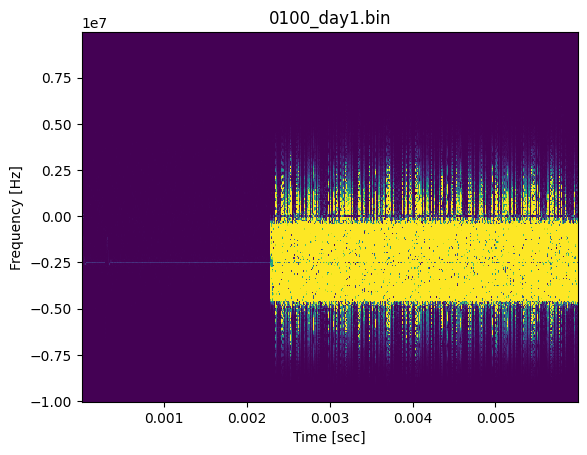

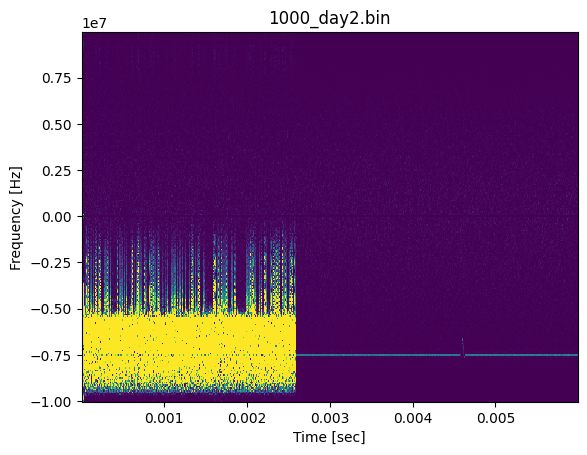

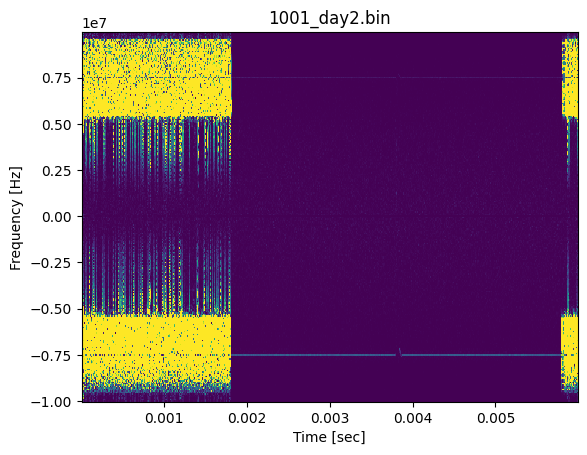

In [22]:
# Iterate through each .bin file and add contents to .h5 file
for file in bin_folder:
    if not os.path.isdir(bin_folder_fp + file):
        with open(bin_folder_fp + file) as binfile:

            # Extract desired number of samples
            samps = np.fromfile(binfile, dtype=np.complex64, count=niq2read, offset=offset)

            # Plot samples
            if plot_spect:

                #Generate spectrogram at sampling rate of 20MHz
                f, t, Sxx = spectrogram(samps, 20000000,return_onesided=False)

                # Compensate for FFT Shift caused by GNU Radio
                Sxx = np.fft.fftshift(Sxx, axes=0)

                # Plot spectrogram
                # play with vmax to better see certain transmissions
                plt.pcolormesh(t, np.fft.fftshift(f), Sxx, shading='auto', vmax=np.max(Sxx)/100)
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [sec]')
                plt.title(file)
                plt.show()

            # Turn 1D complex array of raw samples and reshape into a 2D array containing I and Q as floats
            samps = np.transpose(np.stack((np.real(samps), np.imag(samps))))

            # Break long 2D array containing all I/Q values into multiple training/testing samples with overlap
            # depending on size of input to the CNN and overlap between samples
            samps = np.array([samps[k:k + buf] for k in range(0, len(samps) - 1 - buf, stride)])


            #Create .h5 file with same name as .bin file and fill with reshaped samples
            name = os.path.splitext(file)[0]
            f = h5py.File(h5_folder_fp + name + '.h5', 'w')
            dset = f.create_dataset(name, (samps.shape[0], samps.shape[1], samps.shape[2]), dtype='f')
            dset[()] = samps
            f.close()

In [37]:
import h5py
from sklearn.model_selection import train_test_split
import os as os
import random

In [39]:
# Size of input to 1D CNN or number of complex samples being fed to 1D CNN (should be same as bin2hdf5.py)
buf = 32

# Percentage of dataset that will be used for testing
test_size = 0.1

# Seed used for shuffling dataset
seed = 42

In [40]:
# Filepath containing directory with converted .h5 files
h5_folder_fp = "/Users/hamza/Research/SDR Project/sdr_wifi_h5/"
folder = os.listdir(h5_folder_fp)
folder.sort()

In [41]:
# Generate dummy arrays to be contain entire dataset and dataset labels (can also use list and convert to np.array later)
dataset_labels = np.zeros((1, 4))
dataset = np.zeros((1, buf, 2))

In [44]:
print(h5_folder_fp + file)

/Users/hamza/Research/SDR Project/sdr_wifi_h5/.DS_Store


In [45]:
for file in folder: 
    # Check if the file is an actual file (not a directory) and if it ends with .h5
    if not os.path.isdir(h5_folder_fp + file) and file.endswith('.h5'):

        # Open .h5 folder and extract data
        f = h5py.File(h5_folder_fp + file, 'r')
        name = os.path.splitext(file)[0]
        data = f[name][()]

        # Append samples from current file to dataset
        dataset = np.concatenate((dataset, data))

        # Generates the multi-hot encoded labels from the file name
        label = list(name.split('_')[0])    # Take part of filename that contains labels
        label = list(map(int, label))       # Convert string to multi-hot list
        label = [label] * data.shape[0]     # Generate label for each training sample in file
        label = np.array(label, dtype='i')  # Convert list of labels to np.array
        dataset_labels = np.concatenate((dataset_labels, label))    # Append to labels for entire dataset

f.close()

In [46]:
# Delete first entry of arrays as they contain zeros
dataset = np.delete(dataset, 0, 0)
dataset_labels = np.delete(dataset_labels, 0, 0)

In [47]:
# Shuffle dataset and split into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(
    dataset, dataset_labels, test_size=test_size, random_state=seed)


In [48]:
# Save test set
f_test = h5py.File('./sdr_wifi_test.hdf5', 'w')
xtest = f_test.create_dataset('X', (X_test.shape[0], X_test.shape[1], X_test.shape[2]), dtype='f')
ytest = f_test.create_dataset('y', (y_test.shape[0], y_test.shape[1]), dtype='i')
xtest[()] = X_test
ytest[()] = y_test

In [49]:
# Save train set
f_train = h5py.File('./sdr_wifi_train.hdf5', 'w')
xtrain = f_train.create_dataset('X', (X_train.shape[0], X_train.shape[1], X_train.shape[2]), dtype='f')
ytrain = f_train.create_dataset('y', (y_train.shape[0], y_train.shape[1]), dtype='i')
xtrain[()] = X_train
ytrain[()] = y_train

In [50]:
# Close Files
f_test.close()
f_train.close()